## 1. Get data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pandas as pd

/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_86644/1201507386.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### resolve back index

In [2]:
n_series = [15, 20, 25, 30, 40, 50, 70, 100, 150, 200, 250, 300]
n_totals = [5000, 10000, 15000, 20000, 25000, 30000, 35000]
bs = [0.7, 1.0, 1.3]

all_permutations = [
    i
    for i in it.product(
        n_series,
        n_totals,
        bs,
    )
]
all_permutations = np.array(all_permutations)

# parameter vectors to run through with cl_idx
cl_n_series = all_permutations[:, 0].astype(int)
cl_n_totals = all_permutations[:, 1].astype(int)
cl_bs = all_permutations[:, 2]

def get_string_data(cutting, transform, cl_idx):
    if cutting == "constant_idx":
        save_str = (
            "results/distributions/cutting_" + str(cutting) + "/"
            "acf_mean_" + str(cl_idx) + ".csv"
        )
    else:
        save_str = (
            "results/distributions/cutting_"
            + str(cutting)
            + "/transform_"
            + str(transform)
            + "/"
            "acf_mean_" + str(cl_idx) + ".csv"
        )
    return save_str


def get_df(cutting, transform):
    all_acfs = []
    all_n_series = []
    all_n_series_used = []
    all_bs = []
    all_n_totals = []

    for cl_idx in range(len(cl_n_series)):

        save_str = get_string_data(cutting, transform, cl_idx)

        try :
            acfs = np.genfromtxt('../'+save_str, delimiter=',')
        except :
            acfs = []
        try :
            n_series_used = np.genfromtxt('../'+save_str.replace("acf_mean", "n_used_mean"), delimiter=',')
        except :
            n_series_used = []
        all_acfs.extend(acfs)
        all_n_series_used.extend(n_series_used)
        all_n_series.extend([cl_n_series[cl_idx]]*len(acfs))
        all_bs.extend([cl_bs[cl_idx]]*len(acfs))
        all_n_totals.extend([cl_n_totals[cl_idx]]*len(acfs))

    # make a dataframe
    df = pd.DataFrame({
        "acf": all_acfs,
        "n_series": all_n_series,
        "n_series_used": all_n_series_used,
        "b": all_bs,
        "n_total": all_n_totals,
    })
    return df

## Constant index

In [3]:
cutting = "random"
transform = True

df = get_df(cutting, transform)

In [6]:
grouped_std

,acf,n_series_used,b,n_total
n_series,,,,
15,0.099127,0.040161,0.244961,10000.476224
20,0.089827,0.052304,0.244961,10000.476224
25,0.082787,0.072043,0.244961,10000.476224
30,0.077026,0.098175,0.244961,10000.476224
40,0.067854,0.168891,0.244961,10000.476224
50,0.062295,0.262336,0.244961,10000.476224
70,0.053148,0.514153,0.244961,10000.476224
100,0.044718,1.049409,0.244961,10000.476224
150,0.036978,2.346513,0.244961,10000.476224


0.11674047382957516


/Users/aron/polybox/Projects/b_significant/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'std')

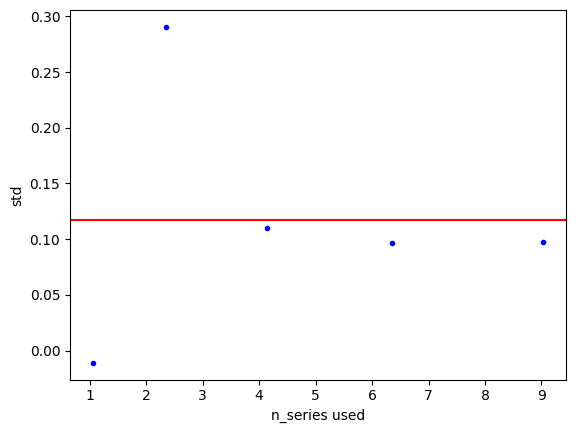

In [4]:
# get the mean value for each group
grouped_mean = df.groupby('n_series').mean()
grouped_std = df.groupby('n_series').std()

# estimate the std (which however, uses the n_series_used, the actual number of series used)
x = grouped_mean['n_series_used']
std = (x-2) / (x*np.sqrt(x-1))
normalized = grouped_std['acf'].values / std

# least squares
gamma = np.mean(normalized)
print(gamma)


plt.plot(x, normalized, color='blue', marker='o', linestyle='', markersize=3)
plt.axhline(y=gamma, color='red')

plt.xlabel("n_series used")
plt.ylabel("std")

In [95]:
# add new collum do df
x = df['n_series_used']
df['acf_th'] = -1/x

std = (x -2) / (x * np.sqrt(x-1))
df['acf_std_th'] = gamma * std


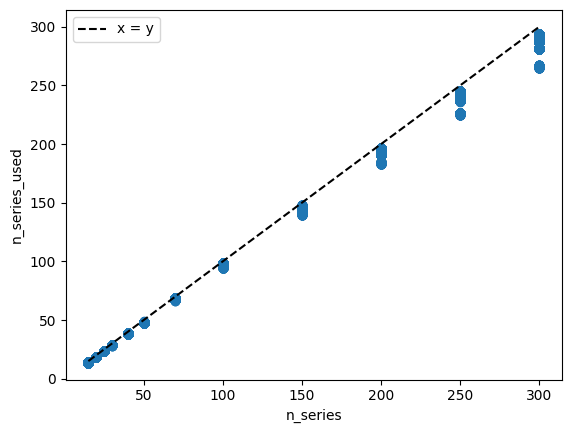

In [96]:
plt.plot(df["n_series"], df["n_series_used"], 'o')
plt.plot(df["n_series"], df["n_series"], 'k--', label ='x = y')
plt.xlabel("n_series")
plt.ylabel("n_series_used")
plt.legend()

In [97]:
# n_series_used
grouped_mean = df.groupby('n_series').mean()
grouped_std = df.groupby('n_series').std()

Text(0, 0.5, 'mean of MAC')

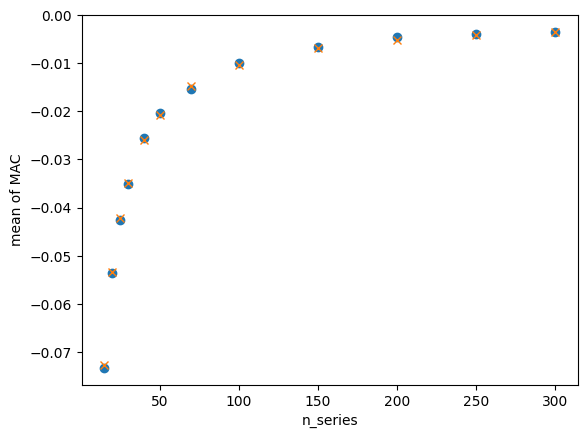

In [98]:
plt.plot(grouped_mean.index, grouped_mean['acf'], 'o', label='empirical')
plt.plot(grouped_mean.index, grouped_mean['acf_th'], 'x', label='theoretical')

plt.xlabel("n_series")
plt.ylabel("mean of MAC")

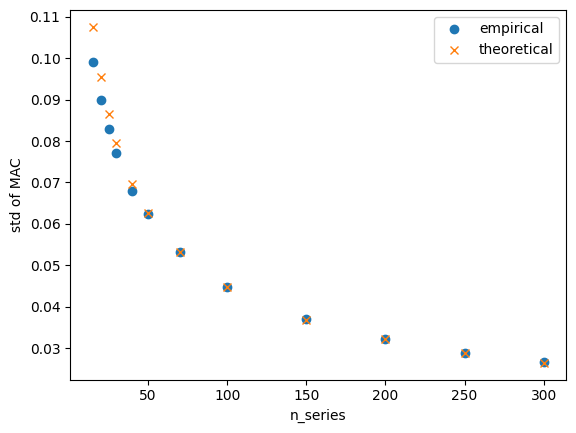

In [99]:

plt.plot(grouped_std.index, grouped_std['acf'], 'o', label='empirical')
plt.plot(grouped_std.index, grouped_mean['acf_std_th'], 'x', label='theoretical')

plt.xlabel("n_series")
plt.ylabel("std of MAC")

plt.legend()

In [100]:
# b
grouped_mean = df.groupby('b').mean()
grouped_std = df.groupby('b').std()

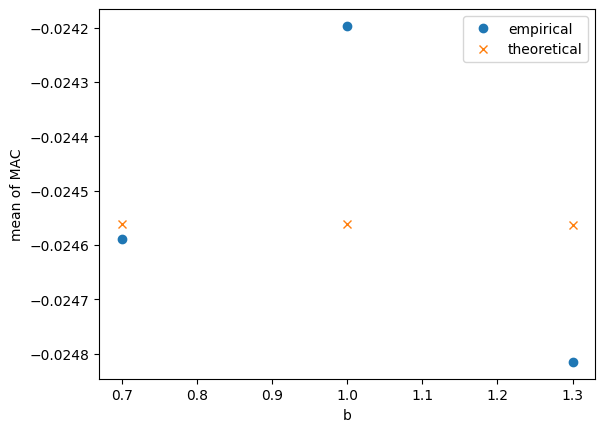

In [101]:
plt.plot(grouped_mean.index, grouped_mean['acf'], 'o', label='empirical')
plt.plot(grouped_mean.index, grouped_mean['acf_th'], 'x', label='theoretical')

plt.xlabel("b")
plt.ylabel("mean of MAC")

plt.legend()

In [102]:
# n_series
grouped_mean = df.groupby('n_total').mean()
grouped_std = df.groupby('n_total').std()

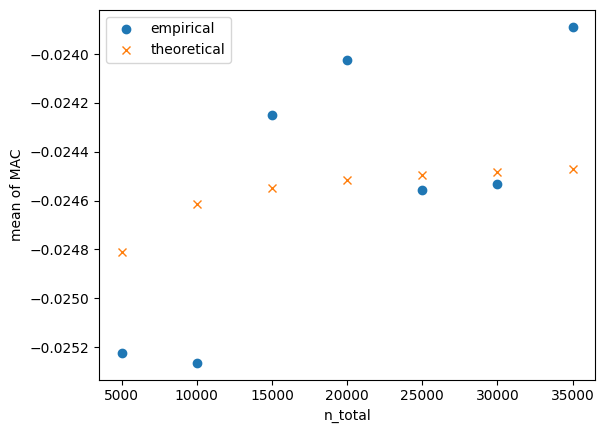

In [103]:
plt.plot(grouped_mean.index, grouped_mean['acf'], 'o', label='empirical')
plt.plot(grouped_mean.index, grouped_mean['acf_th'], 'x', label='theoretical')

plt.xlabel("n_total")
plt.ylabel("mean of MAC")

plt.legend()